# <font color='red'>Examen Data Science</font>

![title](img/st.jpeg)

Escribir su Nombre y Apellido a continuación

Nombre: Diego Demian
Apellido: Vallejos

# Sección A - Desafíos Técnicos

## <font color='red'>1 -Python</font>

### py-1) Vectores, Clases y Objetos

Desarrollar una clase en python que, al instanciar, reciba un vector **weights** y que tenga la siguiente funcionalidad:


* Desarrollar el método **set_weights** que pueda sobrescribir los valores del atributo `weights`
* Desarrollar el método **dot** que permita multiplicar el vector `weigths` por un vector de entrada. (producto escalar)
* Desarrollar el método **predict** que utilice la salida del método dot y lo pasé por la función ReLu. <a href=https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)>Función Relu</a>  
* Desarrollar otra clase que herede el comportamiento de la clase anterior y que además:
  * Reciba un parametro adicional: `bias` (int64)
  * Redefina el método **dot** y al producto le sume el atributo `bias`

In [44]:
import numpy as np
weights = np.array([-4,3,1,-2])

In [45]:
# Escriba aquí su respuesta

class Model(): #Sin bias
    def __init__(self, weights):
        self.weights = weights

    def set_weights(self, weights):
        self.weights = weights

    def dot(self, x):
        return np.dot(self.weights, x)
    
    def predict(self, x):
        return np.maximum(0, self.dot(x))
    

class Biased_Model(Model):
    def __init__(self, weights, bias: int):
        super().__init__(weights)
        self.bias = bias

    def dot(self, x):
        return np.dot(self.weights, x) + self.bias

def relu(X):
   return np.maximum(0,X)

### py-2) Unit test

Desarrollar un test unitario que permita evaluar los métodos de la clase base. 

In [46]:
# Escriba aquí su respuesta
import unittest

class TestModel(unittest.TestCase):
    def setUp(self):
        self.weights_array = np.array([1, 2, 3])
        self.test_weights = Model(self.weights_array)

    def test_set_weights(self):
        new_weights = np.array([4, 5, 6])
        self.test_weights.set_weights(new_weights)
        np.testing.assert_array_equal(self.test_weights.weights, new_weights)

    def test_dot(self):
        x = np.array([4, 5, 6])
        expected_result = np.dot(self.weights_array, x)
        self.assertEqual(self.test_weights.dot(x), expected_result)

    def test_predict_positive(self):
        x = np.array([1, 1, 1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)

    def test_predict_negative(self):
        x = np.array([-1, -1, -1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)


In [48]:
testing = TestModel()
testing.setUp()
testing.test_set_weights()
testing.test_dot()
testing.test_predict_positive()
testing.test_predict_negative()


## <font color='red'>2- SQL</font>

Para el siguiente ejercicio se tiene una base de datos que tiene el siguiente DER:

![title](img/img_der.png)


* Persona (id) puede tener muchas Tarjetas (se relaciona a través de `id_titular`)
* Una Compra siempre es realizada con una única tarjeta
* (EXTRA) La tabla Compra posee un histórico de más de 10 años y varias decenas de millones de registros por lo que las consultas a esta entidad pueden tardar varios minutos si no están correctamente optimizadas.

### sql-1) Query

Obtener los número de tarjeta que no tengan consumos en el último mes pero que pertenecen a personas que hayan comprado al menos un total de $5000 en el último mes en los rubros (FARMACIA y SUPERMERCADOS) en conjunto. (Si es posible, tener en cuenta el punto EXTRA mencionado previamente).


In [2]:
# Escriba aquí su respuesta
print(' Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.')

query_respuesta = """
CREATE INDEX idx_compra_fecha_compra ON compra(fecha_compra);
CREATE INDEX idx_compra_nro_tarjeta ON compra(nro_tarjeta);
CREATE INDEX idx_compra_rubro ON compra(rubro);
CREATE INDEX idx_tarjeta_nro_tarjeta ON tarjeta(nro_tarjeta);
CREATE INDEX idx_tarjeta_id_titular ON tarjeta(id_titular);



WITH tarjetas_sin_compras_utlimo_mes AS (
SELECT t.nro_tarjeta 
FROM Tarjetas AS t
LEFT JOIN (SELECT nro_tarjeta FROM compra WHERE fecha_compra >= DATEADD(MONTH, -1, GETDATE())) AS c
ON t.nro_tarjeta = c.nro_tarjeta
WHERE c.nro_tarjeta IS NULL
)

#Hasta aca creamos indices para las tablas de compra y tarjeta, para poder acceder a los datos de manera mas eficiente. Luego creamos una tabla temporal que nos trae los numeros de tarjeta que no realizaron compras en el ultimo mes.
#Siendo la logica a utilizar hacer un Left Join (que trae los registros que se encuenten en la tabla de la "izquiera" y las coincidentes de la tabla de la "derecha"), esto genera que tengamos ahora todos los numeros de tarjeta
# y solo los que realizaron compras en el ultimo mes. Luego filtramos los que no realizaron compras en el ultimo mes (donde el campo numero de tarjeta es nulo).

SELECT tsc.nro_tarjeta
FROM tarjetas_sin_compras_ultimo_mes tsc
INNER JOIN Tarjetas t ON tsc.nro_tarjeta = t.nro_tarjeta
INNER JOIN (
SELECT t.id_titular
FROM Compra AS c
INNER JOIN Tarjeta AS t ON C.nro_tarjeta = t.nro_tarjeta
WHERE c.fecha_compra >= DATEADD(MONTH, -1, GETDATE())
AND c.rubro IN ('FARMACIA', 'SUPERMERCADO')
GROUP BY t.id_titular
HAVING SUM(c.monto) > 5000
) AS ct ON t.id_titular = ct.id_titular;

#Esta parte es la de la query principal, aca me traigo los numeros de tarjeta de la tabla temproral que no tiene consumos en el ultimo mes uniendolas con un INNER JOIN (me trae solo los registros que este en ambas tablas)
#a la tabla de tarjetas. 
#Hasta aca tengo todos los numeros de tarjeta que no realizaron compras en el ultimo mes y lo uno con la tabla de tarjetas solo porque luego uso t.id_titular y no esta disponible en el cotexto, asi que por ello debo hacer esta union.
#Ahora hago una INNER JOIN con una subconsulta que me trae el id_titular de las compras que se realizaron en el ultimo mes en los subros farmacia y supermercado y que superen los 5000 pesos.

Con esto deberia tener el resultado deseado. La mejora de eficiencia viene del lado del indexado y los joins que se utilizan, ya que se utilizan los que mejor rendimiento tienen en este caso.

"""

print(query_respuesta)

 Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.

CREATE INDEX idx_compra_fecha_compra ON compra(fecha_compra);
CREATE INDEX idx_compra_nro_tarjeta ON compra(nro_tarjeta);
CREATE INDEX idx_compra_rubro ON compra(rubro);
CREATE INDEX idx_tarjeta_nro_tarjeta ON tarjeta(nro_tarjeta);
CREATE INDEX idx_tarjeta_id_titular ON tarjeta(id_titular);



WITH tarjetas_sin_compras_utlimo_mes AS (
SELECT t.nro_tarjeta 
FROM Tarjetas AS t
LEFT JOIN (SELECT nro_tarjeta FROM compra WHERE fecha_compra >= DATEADD(MONTH, -1, GETDATE())) AS c
ON t.nro_tarjeta = c.nro_tarjeta
WHERE c.nro_tarjeta IS NULL
)

#Hasta aca creamos indices para las tablas de compra y tarjeta, para poder acceder a los datos de manera mas eficiente. Luego creamos una tabla temporal que nos trae los numeros de tarjeta que no realizaron compras en el ultimo mes.
#Siendo la logica a utilizar hacer un Left Join (que trae los registros que se encuenten en la ta

### sql-2) Explicar el resultado de la siguiente query

* ¿Qué se obtiene cómo resultado?
* ¿Quiénes son P1, P2 y P3?
* (EXTRA) Si supiera que la tabla persona se carga completa todos los días del año, cada día teniendo una foto guardada con una valor distinto dentro de una variable llamada partition_date. Por ej: uno puede consultar todos los ids de la fecha 2021-05-27 o de la fecha que quiera. ¿Cambiaría algo la siguiente query si quisiera obtener el mismo resultado para la última fecha disponible?


 <font color='blue'>**SELECT**</font> P1.dni,  <font color='red'>COUNT</font> ( <font color='red'>DISTINCT</font>  ( P2.id ) )\
<font color='blue'>**FROM** </font> Persona P1 \
<font color='blue'>**JOIN**</font> Persona P2 on P1.id_padre = P2.id \
<font color='blue'>**JOIN**</font>  Persona P3 on P2.id_padre = P3.id \
<font color='blue'>**WHERE**</font>  P3.sexo = 'MASCULINO' \
<font color='blue'>**GROUP BY**</font>  P1.dni 

In [ ]:
# Escriba aquí su respuesta

Respuesta_query = """
Esta consulta trae el numero de DNI de la persona 1 y el numero de padres unicos que tiene el abuelo masculino de la persona 1.
P1, P2 y P3 son las tablas de personas, donde P1 es la tabla de personas, P2 es la tabla de padres y P3 es la tabla de abuelos.
"""

mejora_query = """
WITH LatestDate AS (
    SELECT MAX(partition_date) AS last_date
    FROM Persona
),
FilteredPersona AS (
    SELECT *
    FROM Persona
    WHERE partition_date = (SELECT last_date FROM LatestDate)
)
SELECT P1.dni, COUNT(DISTINCT(P2.id))
FROM FilteredPersona P1
JOIN FilteredPersona P2 ON P1.id_padre = P2.id
JOIN FilteredPersona P3 ON P2.id_padre = P3.id
WHERE P3.sexo = 'MASCULINO'
GROUP BY P1.dni;


"""

# Sección B - Desafío Machine Learning

#### Enunciado Parte Práctica

El ejercicio consiste en realizar una clasificación de intención de compra online. Para ello se dispondrá de un dataset **online_shoppers_intention.csv** el cual consta de **12.330** registros y **18** columnas
* El target es la columnna **Revenue** 

Para completar el desafío se deberá:
* Realizar un análisis exploratorio de los datos
* Explicar la elección del algoritmo utilizado
* Explicar los resultados obtenidos (Métricas)
* Explicar cuales son las variables que más afectan a la predicción.
* Contestar las siguientes preguntas:
  * *¿El modelo final elegido es bueno? Justificar*
  * *¿Existe overfitting o underfitting?* 

⚠️**ACLARACIONES:**⚠️

- Se tendrá en cuenta la prolijidad del informe. 
- Se tendrá en cuenta la legibilidad del código.
- De ser necesario, dejar asentado los supuestos utilizados por escrito.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [206]:
df = pd.read_csv('online_shoppers_intention.csv')

### Primero le damos una mirada general al dataset

In [5]:
# Escriba el código aquí
print('------------------Primeros 5 registros------------------')
display(df.head())
print('------------------Estadísticas del dataset------------------')
display(df.describe())
print('------------------Nulos del dataset------------------')
display(df.isna().sum()) 

------------------Primeros 5 registros------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


------------------Estadísticas del dataset------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


------------------Nulos del dataset------------------


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Procedemos a hacer el EDA

### Revenue


Tenemos muchos mas datos de Revenue = False que de Revenue = True, por lo que el modelo puede tener un sesgo hacia la clase mayoritaria.


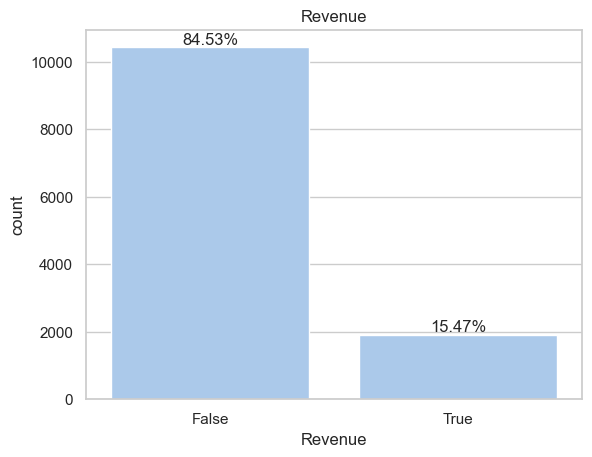

In [53]:
sns.color_palette("pastel")

ax = sns.countplot(data=df, x='Revenue')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Revenue')

print("""
Tenemos muchos mas datos de Revenue = False que de Revenue = True, por lo que el modelo puede tener un sesgo hacia la clase mayoritaria.""")

### Weekend

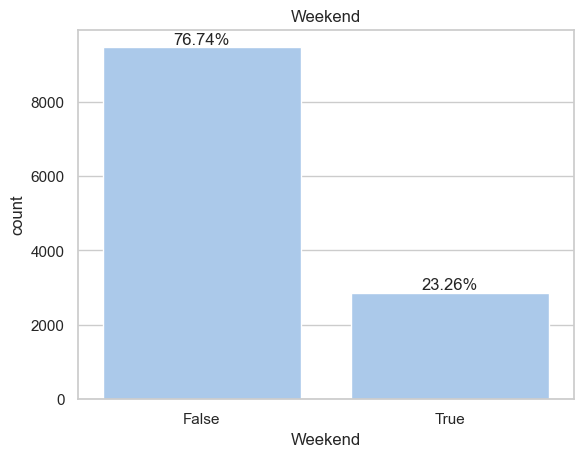

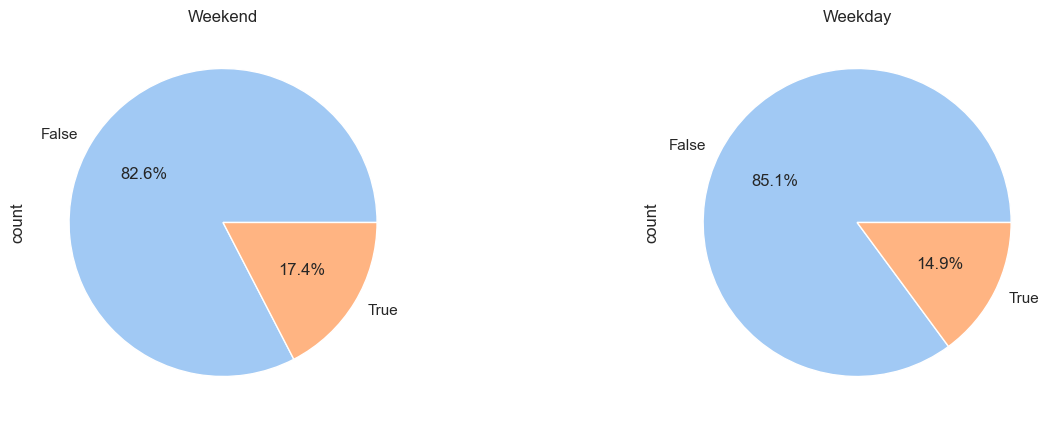


Podemos observar que si bien hay muchos mas datos de dias de semana (lo cual es logico ya que hay mas dias de semana que fin de semana),
cuando comparamos los datos del Revenue por si es dia de semana o no, no hay diferencia significativa en la cantidad de compras que se realizan.


In [52]:
sns.set_palette("pastel")

ax = sns.countplot(data=df, x='Weekend')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Weekend')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df[df['Weekend'] == True]['Revenue'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
df[df['Weekend'] == False]['Revenue'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)

ax1.set_title('Weekend')
ax2.set_title('Weekday')

plt.show()

print("""
Podemos observar que si bien hay muchos mas datos de dias de semana (lo cual es logico ya que hay mas dias de semana que fin de semana),
cuando comparamos los datos del Revenue por si es dia de semana o no, no hay diferencia significativa en la cantidad de compras que se realizan.""")

### ProductRelated

------------------Distribución de ProductRelated_Duration------------------


,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10422.0,1069.987809,1803.797757,0.0,151.00000,510.19000,1331.816667,63973.52223
True,1908.0,1876.209615,2312.214392,0.0,541.90625,1109.90625,2266.011310,27009.85943


------------------Distribución de ProductRelated------------------


,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10422.0,28.714642,40.744717,0.0,6.0,16.0,35.0,705.0
True,1908.0,48.210168,58.267365,0.0,15.0,29.0,57.0,534.0


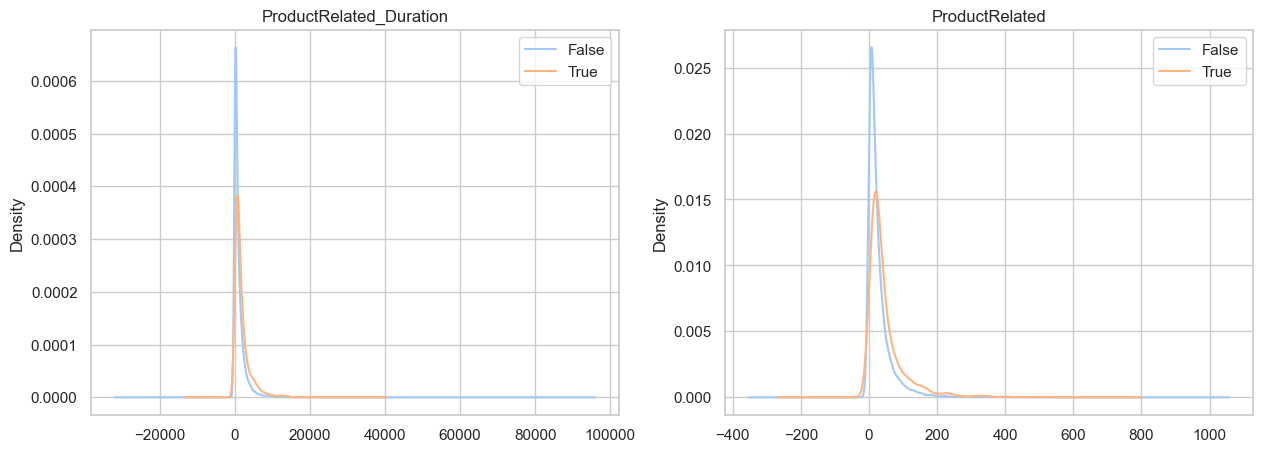

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

print('------------------Distribución de ProductRelated_Duration------------------')
df.groupby('Revenue')['ProductRelated_Duration'].plot(kind='kde', legend=True, ax=ax1)
display(df.groupby('Revenue')['ProductRelated_Duration'].describe())
print('------------------Distribución de ProductRelated------------------')
df.groupby('Revenue')['ProductRelated'].plot(kind='kde', legend=True, ax=ax2)
display(df.groupby('Revenue')['ProductRelated'].describe())


ax1.set_title('ProductRelated_Duration')
ax2.set_title('ProductRelated')

plt.show()

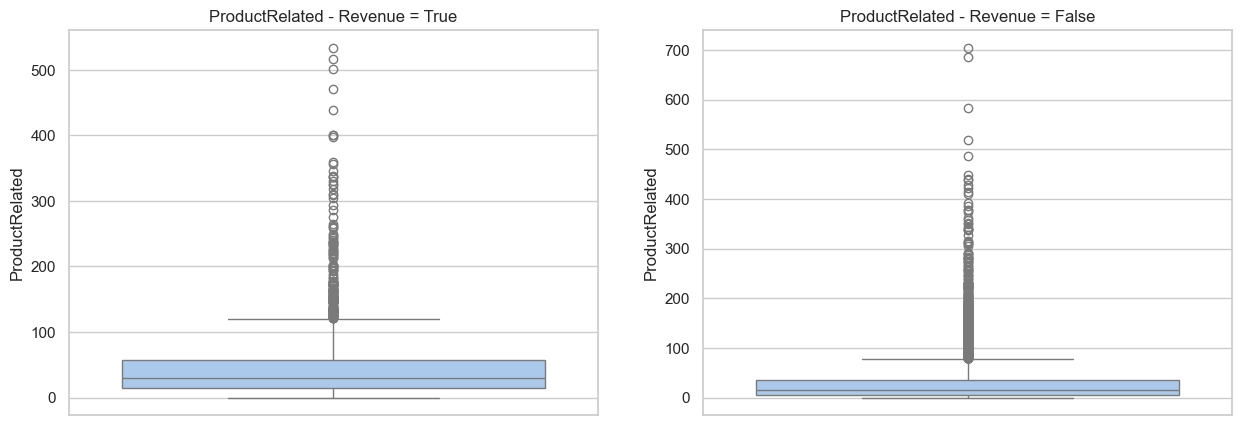

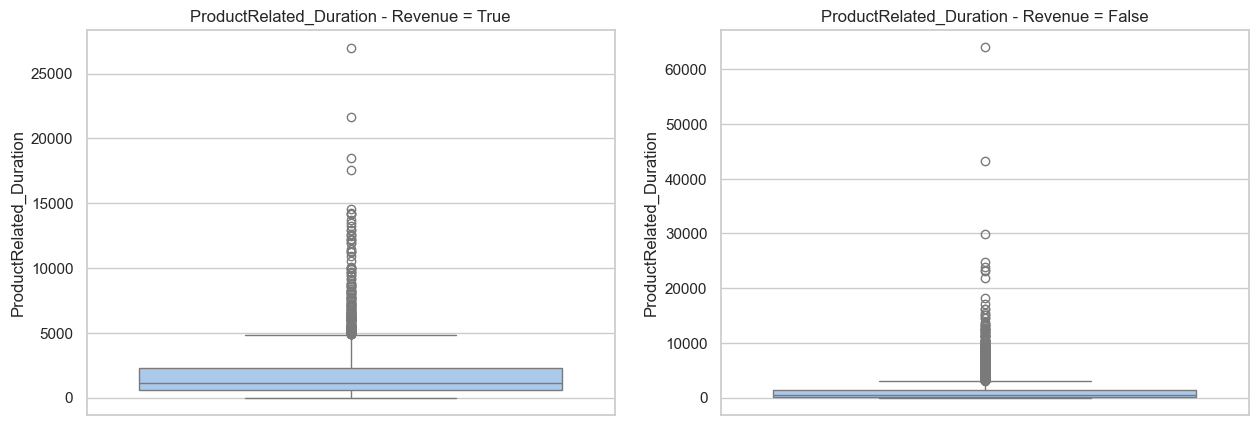

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df[df['Revenue'] == True], y='ProductRelated', ax=ax1)
sns.boxplot(data=df[df['Revenue'] == False], y='ProductRelated', ax=ax2)

ax1.set_title('ProductRelated - Revenue = True')
ax2.set_title('ProductRelated - Revenue = False')

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df[df['Revenue'] == True], y='ProductRelated_Duration', ax=ax1)
sns.boxplot(data=df[df['Revenue'] == False], y='ProductRelated_Duration', ax=ax2)

ax1.set_title('ProductRelated_Duration - Revenue = True')
ax2.set_title('ProductRelated_Duration - Revenue = False')

plt.show()

### Visitor Type

In [12]:
df.VisitorType.value_counts() #este esta interesante para analizar

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

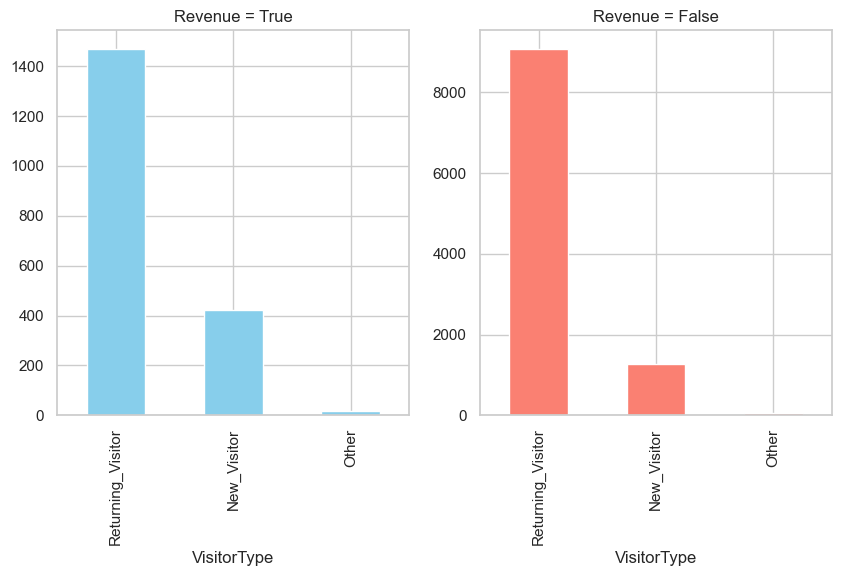


Podemos observar que si bien hay muchos mas falsos que verdaderos, tienen proprociones muy similares en cuanto a la distribución de los tipos de visitantes.
Esto podria indicar que el tipo de visitante no es determinante para distinguir negativos de positivos en Revenue


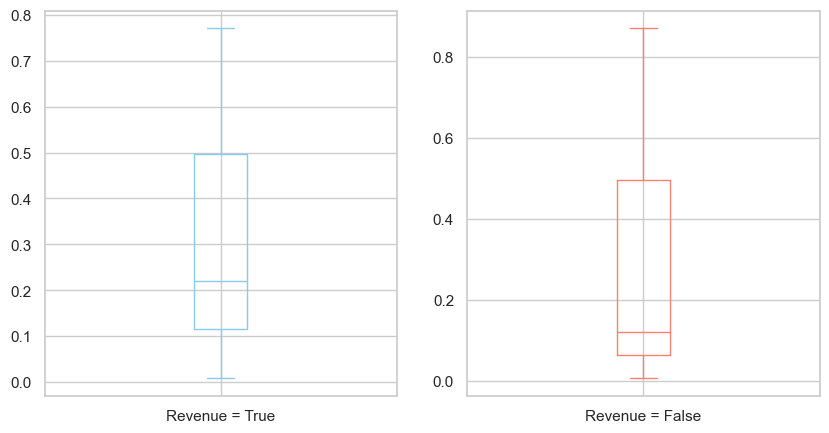

Los boxplots tambien son muy similares


In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

df[df['Revenue'] == True].VisitorType.value_counts().plot(kind='bar', color='skyblue', label='Revenue = True', ax=ax1)
df[df['Revenue'] == False].VisitorType.value_counts().plot(kind='bar', color='salmon', label='Revenue = False', ax=ax2)

ax1.set_title('Revenue = True')
ax2.set_title('Revenue = False')

plt.show()

print("""
Podemos observar que si bien hay muchos mas falsos que verdaderos, tienen proprociones muy similares en cuanto a la distribución de los tipos de visitantes.
Esto podria indicar que el tipo de visitante no es determinante para distinguir negativos de positivos en Revenue""")

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))

df[df['Revenue'] == True].VisitorType.value_counts(normalize=True).plot(kind='box', color='skyblue', label='Revenue = True', ax=ax3)
df[df['Revenue'] == False].VisitorType.value_counts(normalize=True).plot(kind='box', color='salmon', label='Revenue = False', ax=ax4)

plt.show()

print('Los boxplots tambien son muy similares')


### Month

In [42]:
df_revenue = df[df['Revenue'] == True]
df_not_revenue = df[df['Revenue'] == False]

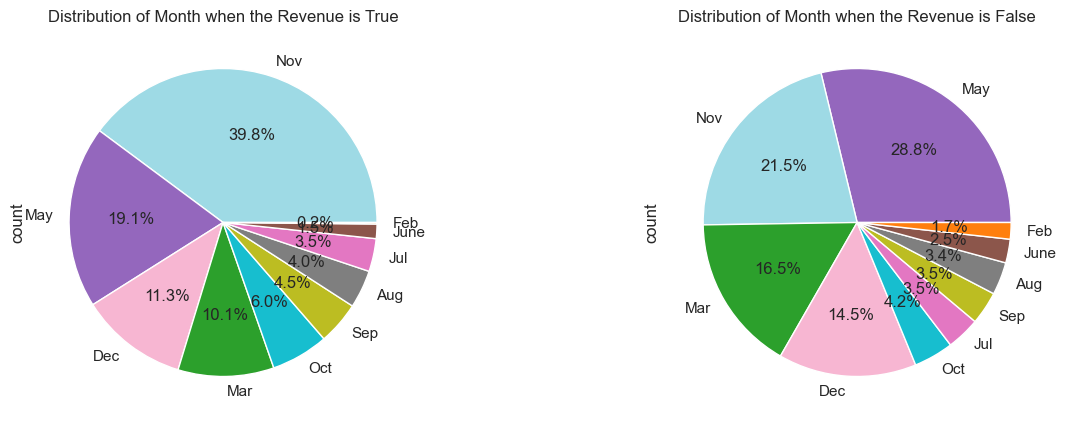

In [43]:
# Define a consistent color map for each month
month_colors = {
    'Jan': '#1f77b4', 'Feb': '#ff7f0e', 'Mar': '#2ca02c',
    'Apr': '#d62728', 'May': '#9467bd', 'June': '#8c564b',
    'Jul': '#e377c2', 'Aug': '#7f7f7f', 'Sep': '#bcbd22',
    'Oct': '#17becf', 'Nov': '#9edae5', 'Dec': '#f7b6d2'
}

# Get the month counts for both dataframes
revenue_month_counts = df_revenue['Month'].value_counts()
not_revenue_month_counts = df_not_revenue['Month'].value_counts()

# Create a color list for each plot based on the month counts index
revenue_colors = [month_colors[month] for month in revenue_month_counts.index]
not_revenue_colors = [month_colors[month] for month in not_revenue_month_counts.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the pie charts with the specified colors
revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=ax1, colors=revenue_colors)
not_revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=ax2, colors=not_revenue_colors)

ax1.set_title('Distribution of Month when the Revenue is True')
ax2.set_title('Distribution of Month when the Revenue is False')

plt.show()




Podemos observar que la distribución de los meses es muy similar en ambos casos, siendo los meses de mayo y noviembre en ambos casos. Los unicos que van cambiando de lugar son los primeros 4
Para el resto se mantiene igual. Esto podria significar que el mes no es un factor determinante para determinar si hay Revenue o no



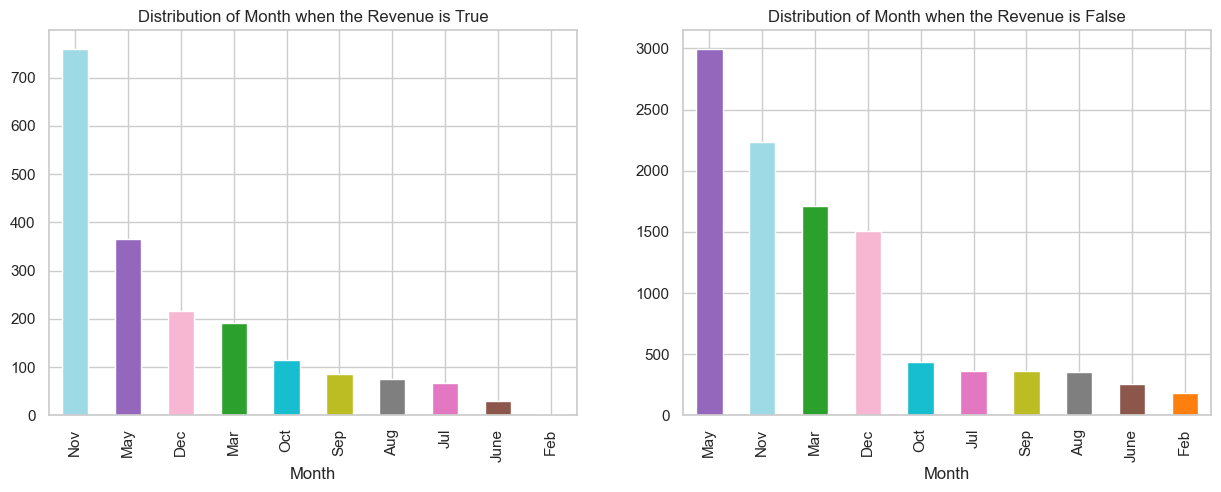

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

revenue_month_counts.plot(kind='bar', color=revenue_colors, ax=ax1)
not_revenue_month_counts.plot(kind='bar', color=not_revenue_colors, ax=ax2)

ax1.set_title('Distribution of Month when the Revenue is True')
ax2.set_title('Distribution of Month when the Revenue is False')

print("""
Podemos observar que la distribución de los meses es muy similar en ambos casos, siendo los meses de mayo y noviembre en ambos casos. Los unicos que van cambiando de lugar son los primeros 4
Para el resto se mantiene igual. Esto podria significar que el mes no es un factor determinante para determinar si hay Revenue o no
""")

## HeatMap para ver las correlaciones entre las variables


Podemos observar que la variable mas correlacionada con Revenue es PageValues, seguido por ExitRates y ProductRelated_Duration.


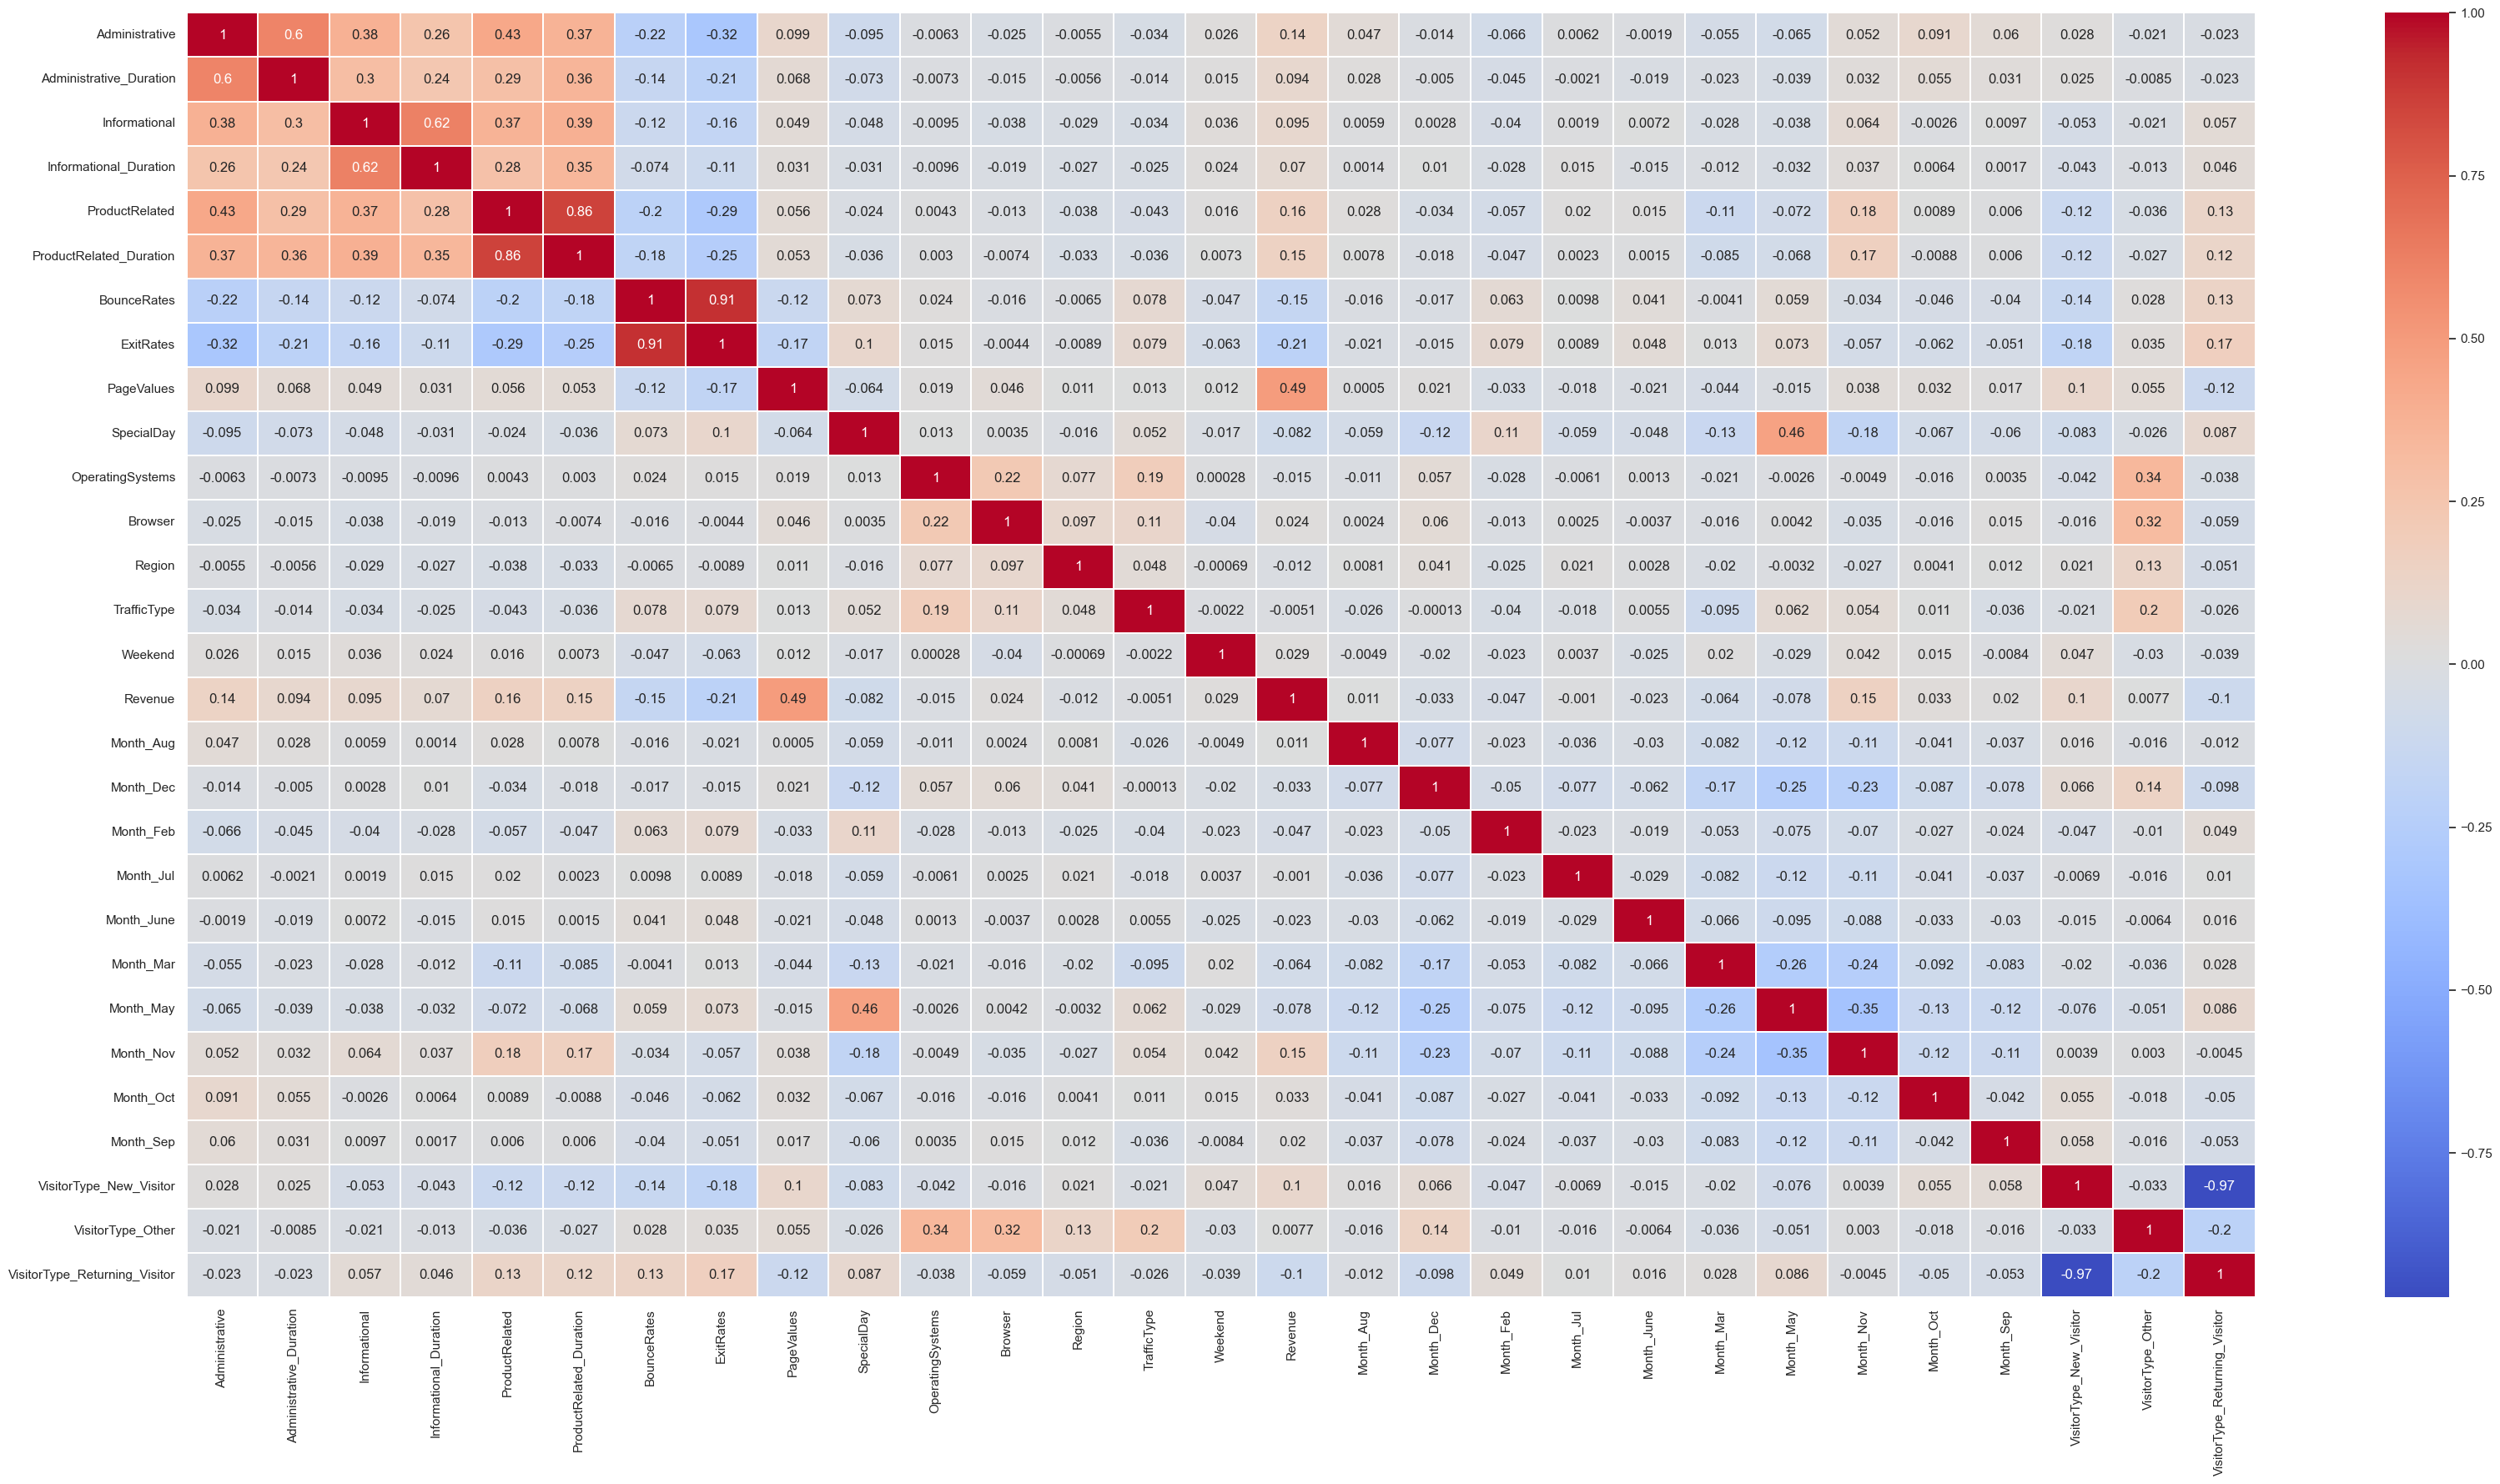

In [92]:
fig, ax = plt.subplots(figsize=(40, 20))

sns.heatmap(pd.get_dummies(df).corr(method='pearson'), cmap='coolwarm', linewidths=0.1, annot=True, ax=ax)

print("""
Podemos observar que la variable mas correlacionada con Revenue es PageValues, seguido por ExitRates y ProductRelated_Duration.""")

### Page values

------------------Distribución de PageValues------------------


count    12330.000000
mean         5.889258
std         18.568437
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64

PageValues
0.000000     9600
53.988000       6
42.293068       3
59.988000       2
16.158558       2
             ... 
6.673696        1
6.094324        1
28.253955       1
16.090650       1
12.241717       1
Name: count, Length: 2704, dtype: int64

Text(0.5, 1.0, 'PageValues - Revenue = False')

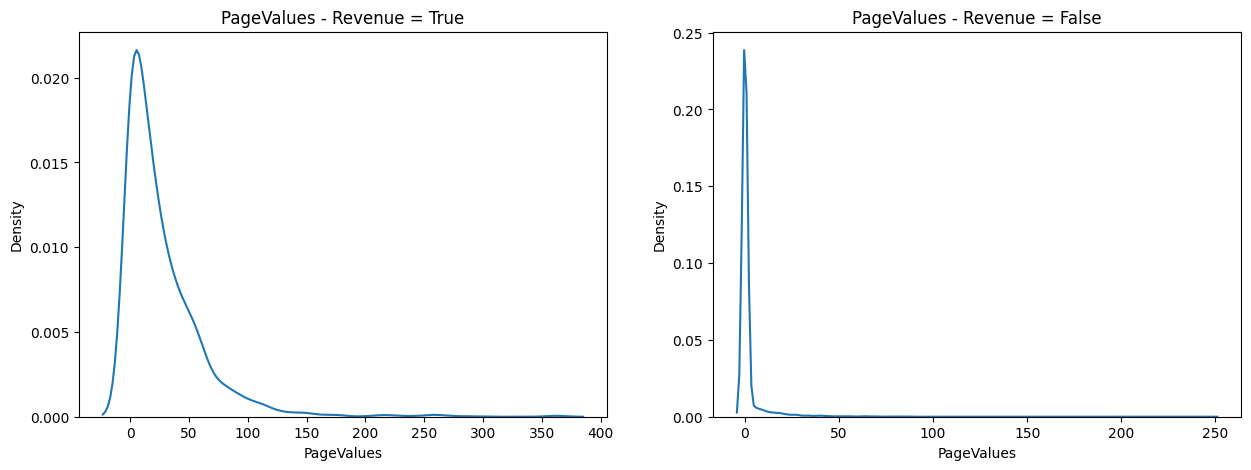

In [9]:
print('------------------Distribución de PageValues------------------')


display(df.PageValues.describe())
display(df.PageValues.value_counts())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df[df['Revenue']==True], x='PageValues', ax=ax1)
sns.kdeplot(data=df[df['Revenue']==False], x='PageValues', ax=ax2)

ax1.set_title('PageValues - Revenue = True')
ax2.set_title('PageValues - Revenue = False')

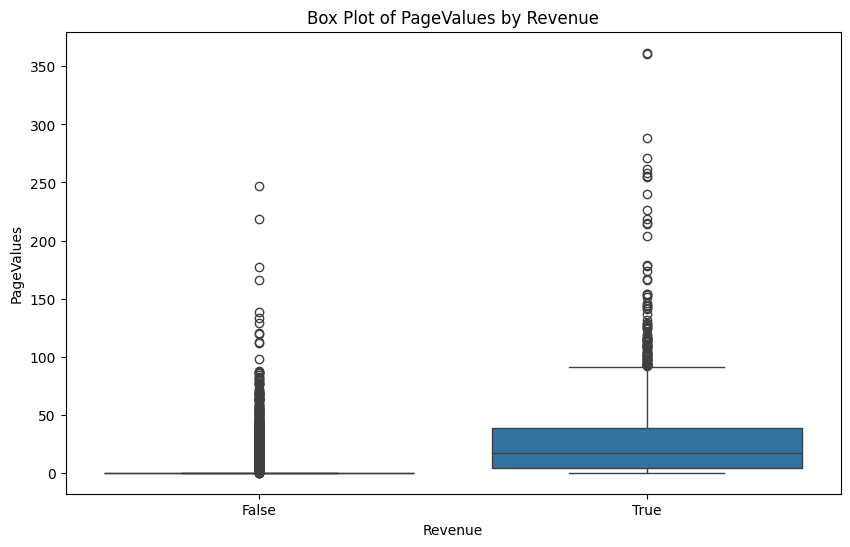

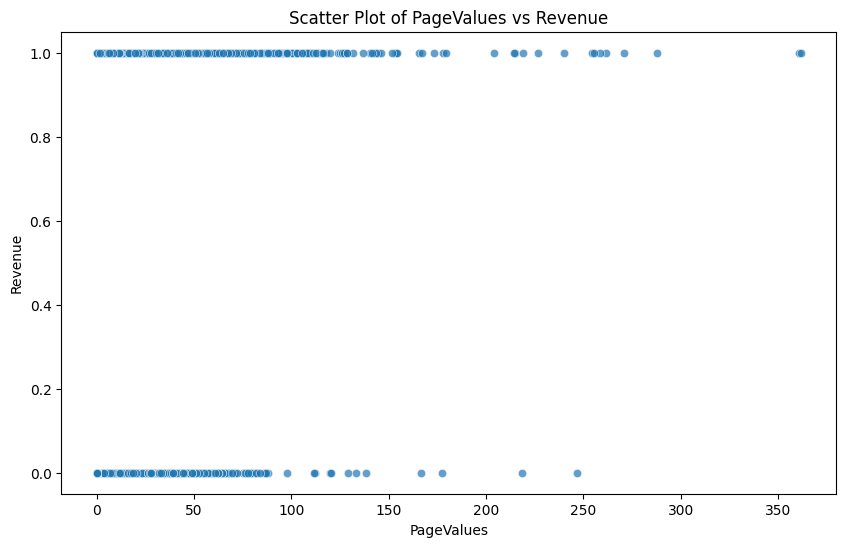

 En el segundo grafico podemos ver que los valores de Pagevalues son mayores en los casos de Revenue = True, lo que podria indicar que es una variable importante para predecir si hay Revenue o no.


In [13]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Revenue', y='PageValues', data=df)
plt.title('Box Plot of PageValues by Revenue')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='PageValues', y='Revenue', data=df, alpha=0.7)
plt.title('Scatter Plot of PageValues vs Revenue')
plt.xlabel('PageValues')
plt.ylabel('Revenue')
plt.show()

print(""" En el segundo grafico podemos ver que los valores de Pagevalues son mayores en los casos de Revenue = True, lo que podria indicar que es una variable importante para predecir si hay Revenue o no.""")

## Exit Rates

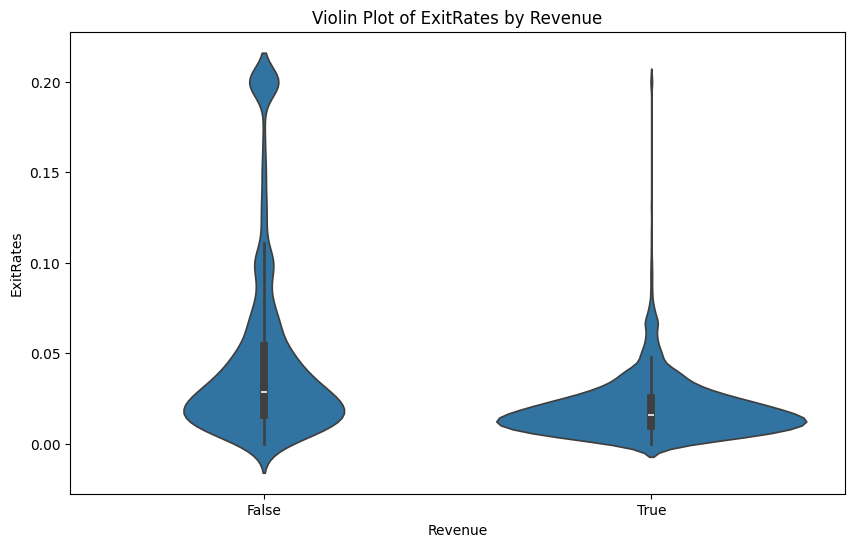

Text(0.5, 1.0, 'Swarm Plot of ExitRates by Revenue')

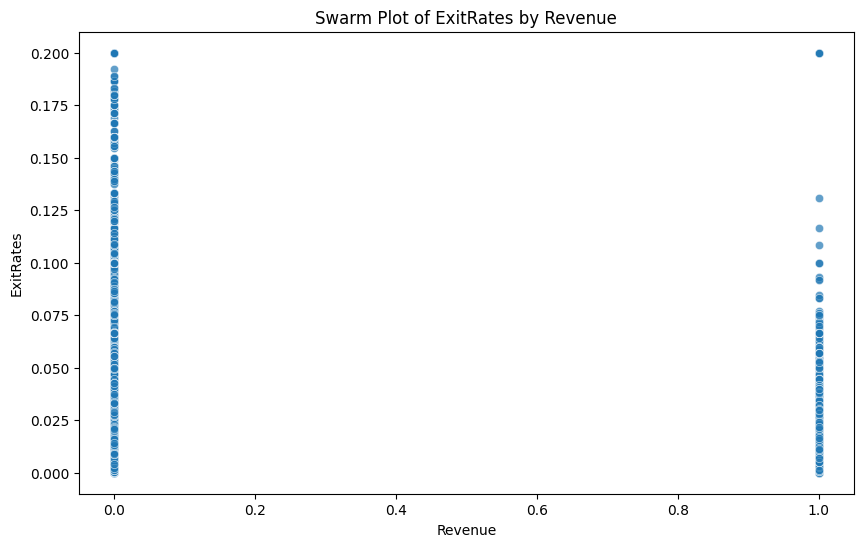

In [7]:

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Revenue', y='ExitRates', data=df)
plt.title('Violin Plot of ExitRates by Revenue')
plt.show()

# Swarm Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Revenue', y='ExitRates', data=df, alpha=0.7)
plt.title('Swarm Plot of ExitRates by Revenue')

print("""""")

### Region

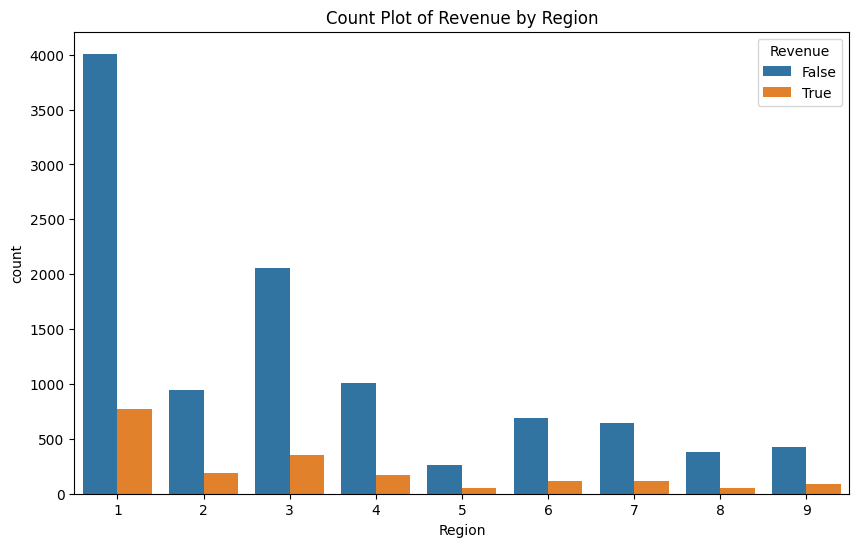

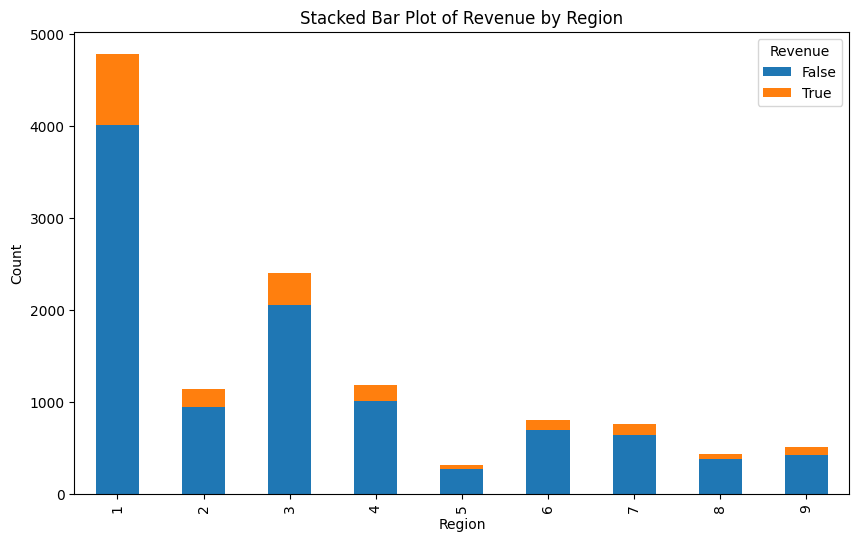

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Region', hue='Revenue', data=df)
plt.title('Count Plot of Revenue by Region')
plt.show()

# Stacked Bar Plot
region_revenue_counts = df.groupby(['Region', 'Revenue']).size().unstack().fillna(0)
region_revenue_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Plot of Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Revenue')
plt.show()

## Analsis de outliers

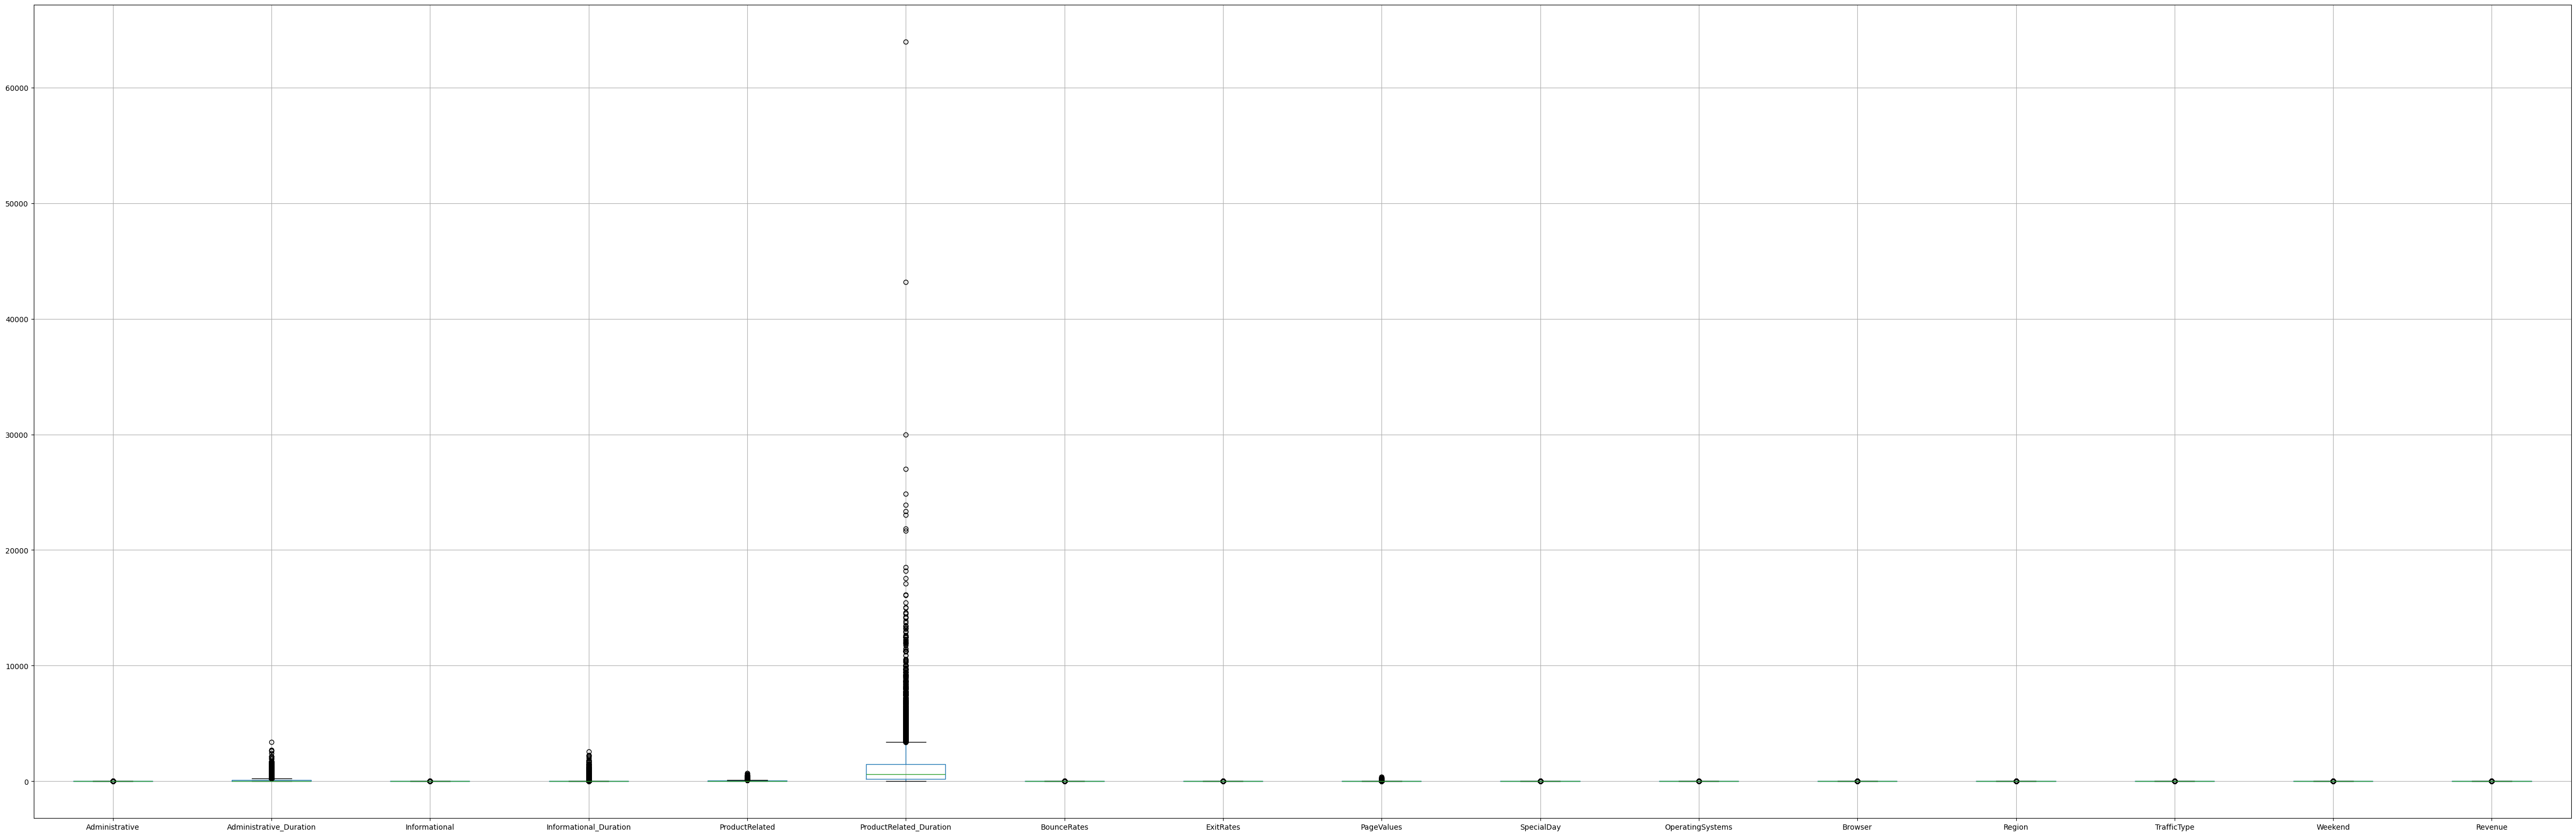

In [10]:
plt.figure(figsize=(62, 20))
df.boxplot();

In [11]:
from numpy import mean, std

# List to store the percentage of outliers for each column

numerical_columns = df.select_dtypes(include=[np.number]).columns
outlier_percentages = []

# Loop through each numerical column to calculate outliers
for column in numerical_columns:
    column_mean = mean(df[column])
    column_std = std(df[column])
    
    # Calculate the cutoff for identifying outliers
    threshold = column_std * 3
    lower_bound, upper_bound = column_mean - threshold, column_mean + threshold
    
    print(f'Analyzing {column}: \n')

    # Identify outliers based on the cutoff
    outliers = [value for value in df[column] if value < lower_bound or value > upper_bound]
    outlier_count = len(outliers)
    
    print(f'Number of outliers: {outlier_count}')
    
    # Identify non-outliers
    non_outliers = [value for value in df[column] if lower_bound <= value <= upper_bound]
    non_outlier_count = len(non_outliers)
    
    print(f'Number of non-outlier observations: {non_outlier_count}')
    
    # Calculate the percentage of outliers
    percentage_outliers = (outlier_count / (outlier_count + non_outlier_count)) * 100
    print(f'Outlier percentage: {percentage_outliers:.2f}%\n')
    
    # Append the percentage to the list
    outlier_percentages.append(percentage_outliers)


Analyzing Administrative: 

Number of outliers: 213
Number of non-outlier observations: 12117
Outlier percentage: 1.73%

Analyzing Administrative_Duration: 

Number of outliers: 232
Number of non-outlier observations: 12098
Outlier percentage: 1.88%

Analyzing Informational: 

Number of outliers: 260
Number of non-outlier observations: 12070
Outlier percentage: 2.11%

Analyzing Informational_Duration: 

Number of outliers: 230
Number of non-outlier observations: 12100
Outlier percentage: 1.87%

Analyzing ProductRelated: 

Number of outliers: 236
Number of non-outlier observations: 12094
Outlier percentage: 1.91%

Analyzing ProductRelated_Duration: 

Number of outliers: 219
Number of non-outlier observations: 12111
Outlier percentage: 1.78%

Analyzing BounceRates: 

Number of outliers: 708
Number of non-outlier observations: 11622
Outlier percentage: 5.74%

Analyzing ExitRates: 

Number of outliers: 713
Number of non-outlier observations: 11617
Outlier percentage: 5.78%

Analyzing PageV

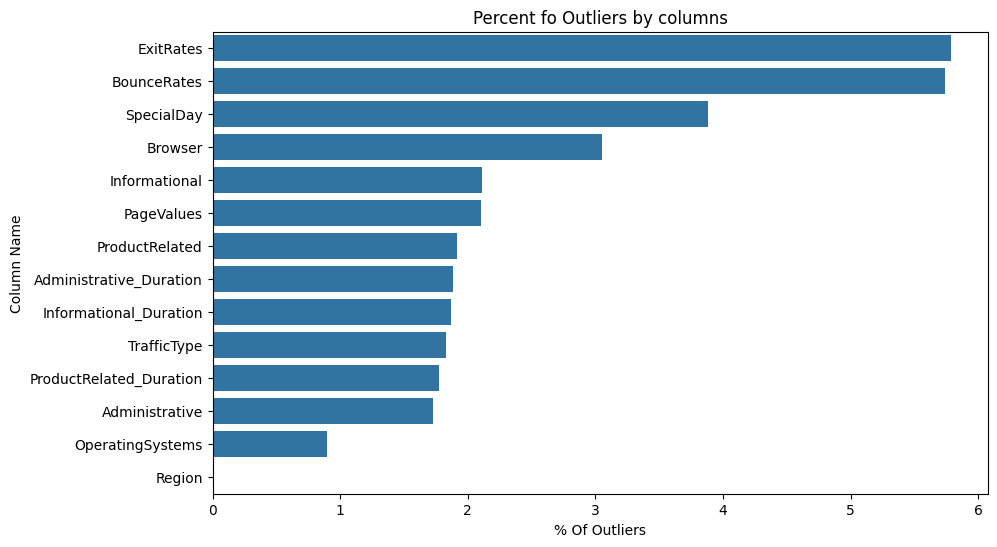

In [17]:
Outliers = pd.DataFrame({'Feature': numerical_columns, '% Of Outliers': outlier_percentages})
outlier_sorted = Outliers.sort_values('% Of Outliers', ascending = False)

fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(y = outlier_sorted['Feature'], x = outlier_sorted['% Of Outliers'], ax=ax)
plt.title('Percent fo Outliers by columns')
plt.ylabel('Column Name')
plt.show()

## Machine learning

Para esta parte voy a elegir y justificar una metrica de base para elegir el modelo y el algoritmo.
- Primero inicializo un diccionario con diferentes tipos de algoritmos para clasificación:
---
- XGBoost Classifier: 
- Logistic Regression:
- MLP Classifier:
- Random Forest Classifier:
---
- Las metricas que seran tenidas en cuenta son:
---
- F1 Score:
- AUC-ROC:
---
Nota: Podria elegir otras matricas como accuracy, Precision, Recall, etc.
Pero para el problema actual que consiste en predecir si hay una venta dadas la visita del consumidor al sitio online, deberia ver cual seria el caso de uso del modelo.
Dependiendo de para que se usaria usaria una metrica u otra. Por ejemplo: en caso de que se hiciera para utilizarlo en una campaña publicitaria, me interesaria maximizar la precision (de las veces que dije que es un 1, cuantas era realmente un 1) en vez del recall (de todos los 1, a cuantos le acerte). Ya que priorizando esta minimizaria el costo de la campaña.

Primero va el preprocesado

Nota 2:
En una situacion real podria preguntar al negocio que significan ciertas columnas, para ver que significa la columna "Administrative" por ejemplo, si es una cantidad o son categorias. 
Dado que en esta situacion no lo se, lo tratare con una cantidad.
El OperatingSystems, Browser, Region, TrafficType las tomare como categoricas



In [274]:
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve, make_scorer, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [207]:
categorical_columns = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']

le = LabelEncoder()
df['Revenue'] = le.fit_transform(df['Revenue'])

df = pd.get_dummies(df, drop_first=True, columns=categorical_columns, dtype='int64')

X_train, X_test, y_train, y_test = train_test_split(df.drop('Revenue', axis=1), df['Revenue'], test_size=0.2)



Una vez que splitee los datos, toca el escalado de features y encoding. Siempre debe ser despues del split para evitar data leaking

In [250]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Ahora estamos listos para Entrenar los modelos

In [262]:
roc_aucs = []
f1s = []
model_instances = []

models = {'Logistic Regression': 0,
          'Random Forest': 0,
          'MLP' : 0, 
          'xgb': 0}


1) Logistic Regression 

In [263]:
model = LogisticRegression()

log_reg_grid_search = GridSearchCV(model, param_grid = {'class_weight' : ['balanced', None]}, cv = 5, scoring = 'roc_auc', n_jobs = -1)
log_reg_grid_search.fit(X_train_scaled, y_train)

best_log = log_reg_grid_search.best_estimator_
model_instances.append(best_log)

y_pred_train = best_log.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_log.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['Logistic Regression'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F1 Score on Train Set: 0.5139425139425139
F1 Score on Test Set: 0.5287356321839081


c:\Users\diego\Projects\SanTec-Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [264]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2080
           1       0.72      0.42      0.53       386

    accuracy                           0.88      2466
   macro avg       0.81      0.69      0.73      2466
weighted avg       0.87      0.88      0.87      2466



2) Random Forest

In [265]:
model = RandomForestClassifier()

rf_param_grid = {'n_estimators': [80 ,100, 200, 300],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5, 10]}

rf_grid_search = GridSearchCV(model, param_grid = rf_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
rf_grid_search.fit(X_train_scaled, y_train)

best_rf = rf_grid_search.best_estimator_
model_instances.append(best_rf)

y_pred_train = best_rf.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_rf.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['Random Forest'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F1 Score on Train Set: 0.11742892459826947
AUC-ROC on Train Set: 0.5311489979462095
--------------------------------
F1 Score on Test Set: 0.09852216748768473
AUC-ROC on Test Set: 0.5259067357512953


In [266]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2080
           1       1.00      0.05      0.10       386

    accuracy                           0.85      2466
   macro avg       0.93      0.53      0.51      2466
weighted avg       0.87      0.85      0.79      2466



3) MLP Classifier

In [267]:
model = MLPClassifier()

mlp_param_grid = {'solver': ['lbfgs'],
                'hidden_layer_sizes':np.arange(10, 35) ,
                'max_iter': [300,500, 800, 1000], # Iteraciones máximas en cada red
                'alpha': 10.0 ** -np.arange(0.5, 2)} # Parámetro de regularización L2 para evitar sobreajuste
}

mlp_grid_search = GridSearchCV(model, param_grid = mlp_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
mlp_grid_search.fit(X_train_scaled, y_train)

best_mlp = mlp_grid_search.best_estimator_
model_instances.append(best_mlp)

y_pred_train = best_mlp.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_mlp.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['MLP'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F1 Score on Train Set: 0.0
F1 Score on Test Set: 0.0


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

4) XGBoost Classifier

In [ ]:
model = xgb.XGBoostClassifier()

xgb_param_grid = {'n_estimators': [100, 200, 300],
                    'max_depth': [3, 4, 5],
                    'learning_rate': [0.1, 0.01, 0.001]}
}

xgb_grid_search = GridSearchCV(model, param_grid = xgb_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
xgb_grid_search.fit(X_train_scaled, y_train)

best_xgb = xgb_grid_search.best_estimator_
model_instances.append(best_xgb)

y_pred_train = best_xgb.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_xgb.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['xgb'] = roc_auc

print('------------------------------')

roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Model evaluation

In [258]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [259]:
import sklearn.metrics as met
met.get_scorer_names()[-1:]

['v_measure_score']

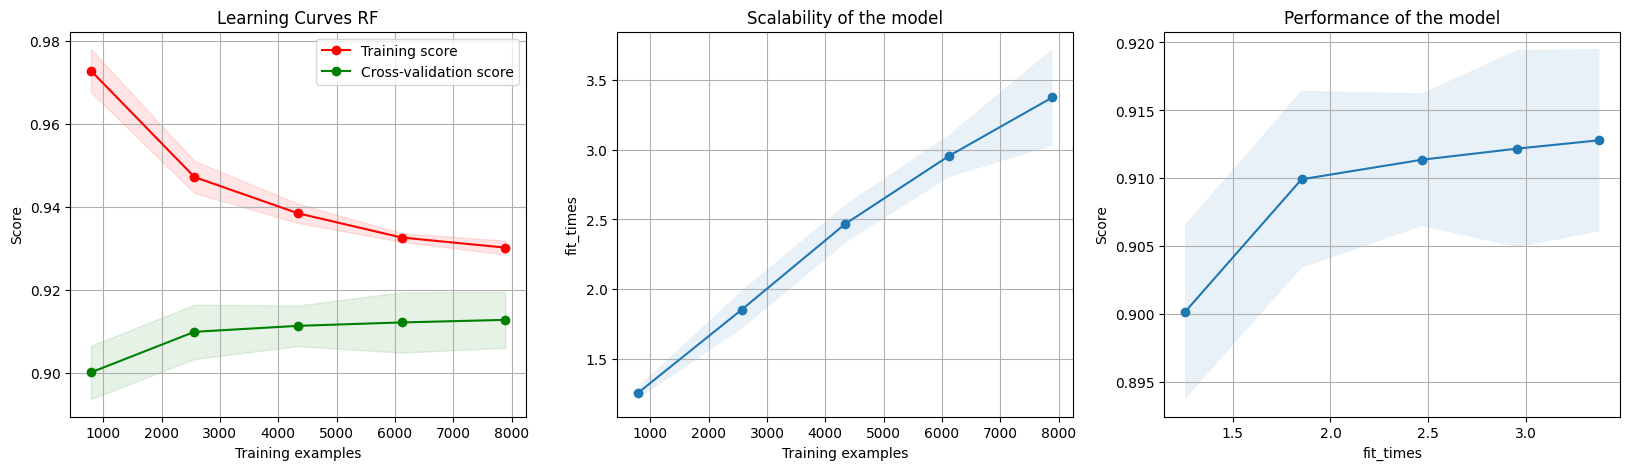

In [271]:
# fig, ax = plt.subplots(3, 1, figsize=(10, 15))

X, y = X_train, y_train

title = "Learning Curves RF"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = best_rf

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4,scoring="roc_auc"
)

plt.show()